# Температура обработки стали. 

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [Подгрузка библиотек и самописные функции](#0.)
* [Загрузка данных](#1.)
* [Часть 1.Исследовательский анализ данных](#8.)
    * [Данные об электродах](#2.)
    * [Данные о подаче сыпучих материалов (объём, время подачи)](#3.)
    * [Данные данные о продувке сплава газом](#4.)
    * [Данные о проволочных материалах (объём, время)](#5.)
    * [Результаты измерения температуры](#6.)
    * [Список уточняющих вопросов и Примерный план решения задачи.](#7.)
* [Часть 2. Код решения](#9.)
    * [Чистка данных](#10.)
    * [Подготовка данных для модели](#11.)
    * [Построение модели](#12.)
    * [Тестирование модели](#13.)
    * [Проверка модели на адекватность](#14.)
    * [Вывод](#15.)
* [Часть 3. Отчет по решению](#16.)

## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## План работы:
    
* Проведите исследовательский анализ данных. 
* В конце Jupyter Notebook напишите:
    * Список уточняющих вопросов.
    * Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Подгрузка библиотек и самописные функции
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [47]:
# !pip install lazypredict
# !pip install pytest
# !pip install Cython

In [48]:
import numpy as np
import pandas as pd
import time

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError

from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.ensemble import IsolationForest

#Убираем ворнинги
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning

%config InlineBackend.figure_format='retina'

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)


import lazypredict
from lazypredict.Supervised import LazyRegressor

In [49]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

In [50]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        
#* duplicat - 1: вывод количества полных дублей
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод

def print_basic_info(base, info, describe, duplicat, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

## Загрузка данных
<a name="1."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [51]:
#Работаю локально, онлайн путь в хабе немного другой ('/datasets/...')

data_arc = pd.read_csv('datasets/data_arc.csv', sep=',',decimal='.')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv', sep=',',decimal='.')
data_bulk = pd.read_csv('datasets/data_bulk.csv', sep=',',decimal='.')
data_gas = pd.read_csv('datasets/data_gas.csv', sep=',',decimal='.')
data_temp = pd.read_csv('datasets/data_temp.csv', sep=',',decimal='.')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv', sep=',',decimal='.')
data_wire = pd.read_csv('datasets/data_wire.csv', sep=',',decimal='.')

<!-- # data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
# data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
# data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
# data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
# data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
# data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
# data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') -->

## Исследовательский анализ данных
<a name="8."></a>
[<font size="2">(к содержанию)</font>](#1common.)

### Данные об электродах (data_arc)
<a name="2."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [52]:
#данные об электродах;
print_basic_info(data_arc,1,1,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_arc['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

  head 


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02               0.98   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33               0.81   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36               0.74   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19               1.66   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37               0.69   

   Реактивная мощность  
0                 0.69  
1                 0.52  
2                 0.50  
3                 1.06  
4                 0.41


  describe  


  key  
 count     14876.00
mean       1615.22
std         934.57
min           1.00
25%         806.00
50%        1617.00
75%        2429.00
max        3241.00
Name: key, dtype: float64

  Начало нагрева дугой  
 count                   14876
unique                  14875
top       2019-06-10 22:02:03
freq                        2
Name: Начало нагрева дугой, dtype: object

  Конец нагрева дугой  
 count                   14876
unique                  14876
top       2019-08-07 02:53:21
freq                        1
Name: Конец нагрева дугой, dtype: object

  Активная мощность  
 count     14876.00
mean          0.67
std           0.41
min           0.03
25%           0.40
50%           0.56
75%           0.86
max           3.73
Name: Активная мощность, dtype: float64

  Реактивная мощность  
 count     14876.00
mean          0.45
std           5.88
min        -715.50
25%           0.29
50%           0.42
75%           0.64
max           2.68
Name: Реактивная мощность, 

3214

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

In [53]:
#Минусовая реактивная мощность? 
data_arc[data_arc['Реактивная мощность'] < 0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37               0.50   

      Реактивная мощность  
9780              -715.50

In [54]:
#Единичый случай - заменим на медианное значение партии ...

data_arc.loc[9780,'Реактивная мощность'] = data_arc[(data_arc['Реактивная мощность'] >= 0) 
    &(data_arc['key'] == 2116)]['Реактивная мощность'].median()

In [55]:
#..и проверим.
data_arc[data_arc['Реактивная мощность'] < 0]

Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []

In [56]:
# посчитаем время
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')                        

data_arc['arc_heating_seconds'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [57]:
#сделаем таблицу
pivot_data_arc = data_arc.pivot_table(index='key', 
                                      values=['arc_heating_seconds','Активная мощность','Реактивная мощность'], 
                                      aggfunc=['count','mean','sum'])

In [58]:
pivot_data_arc.columns = (['count','_count','__count','arc_heating_seconds','mean_active_power',
                           'mean_reactive_power', 'sum_arc_heating_seconds',"_sum","__sum"])
pivot_data_arc.drop(['_count','__count','__sum','_sum'], axis=1, inplace = True)

In [59]:
#сделаем таблицу

data_arc['ratio_active_to_reactive'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']
pivot_ratio = data_arc.pivot_table(index='key', 
                                      values='ratio_active_to_reactive', 
                                      aggfunc='mean')
pivot_data_arc = pivot_data_arc.join(pivot_ratio)

In [60]:
pivot_data_arc.head(3)

count  arc_heating_seconds  mean_active_power  mean_reactive_power  \
key                                                                       
1        5               219.60               0.98                 0.64   
2        4               202.75               0.76                 0.50   
3        5               131.00               0.51                 0.32   

     sum_arc_heating_seconds  ratio_active_to_reactive  
key                                                     
1                       1098                      1.54  
2                        811                      1.55  
3                        655                      1.58

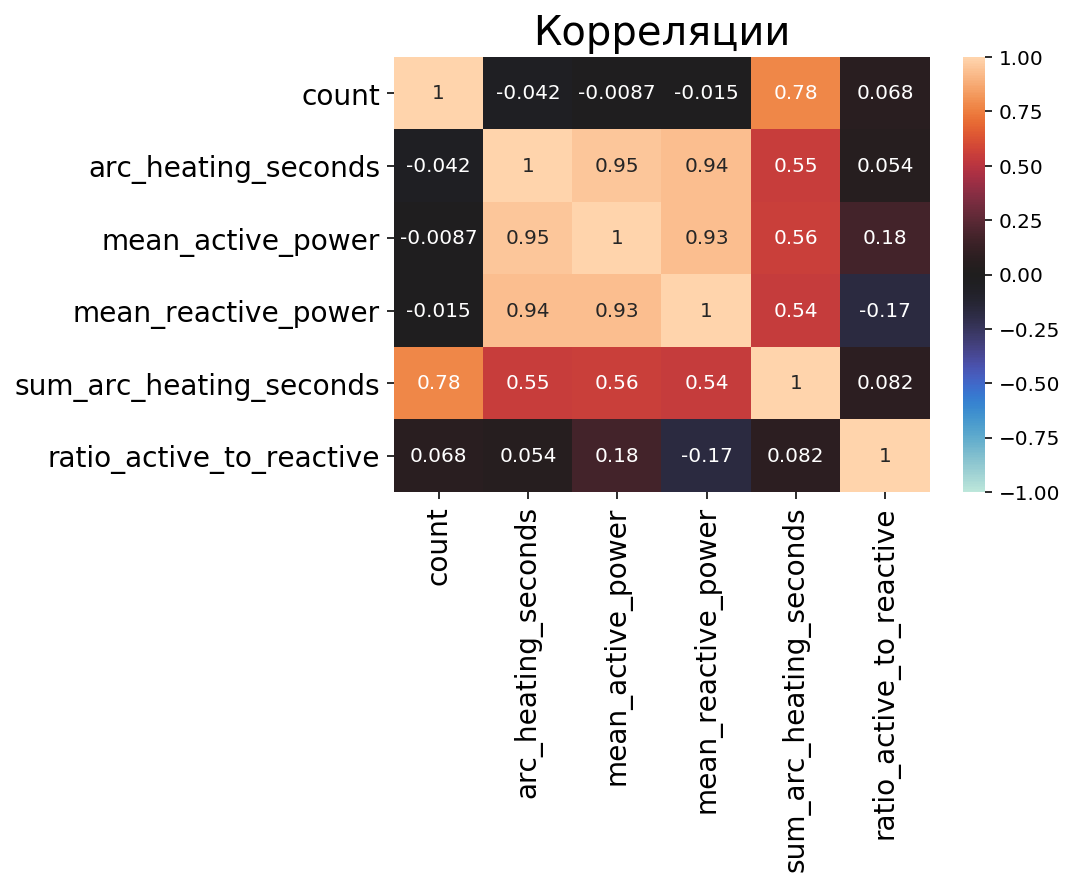

In [61]:
# проверим на мультиколлениальность и возможно уберем некоторые столбцы из анализа 

corr = pivot_data_arc.corr()
sns.heatmap(corr, center=0, annot=True, vmin=-1, vmax=1 )
plt.title("Корреляции", fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

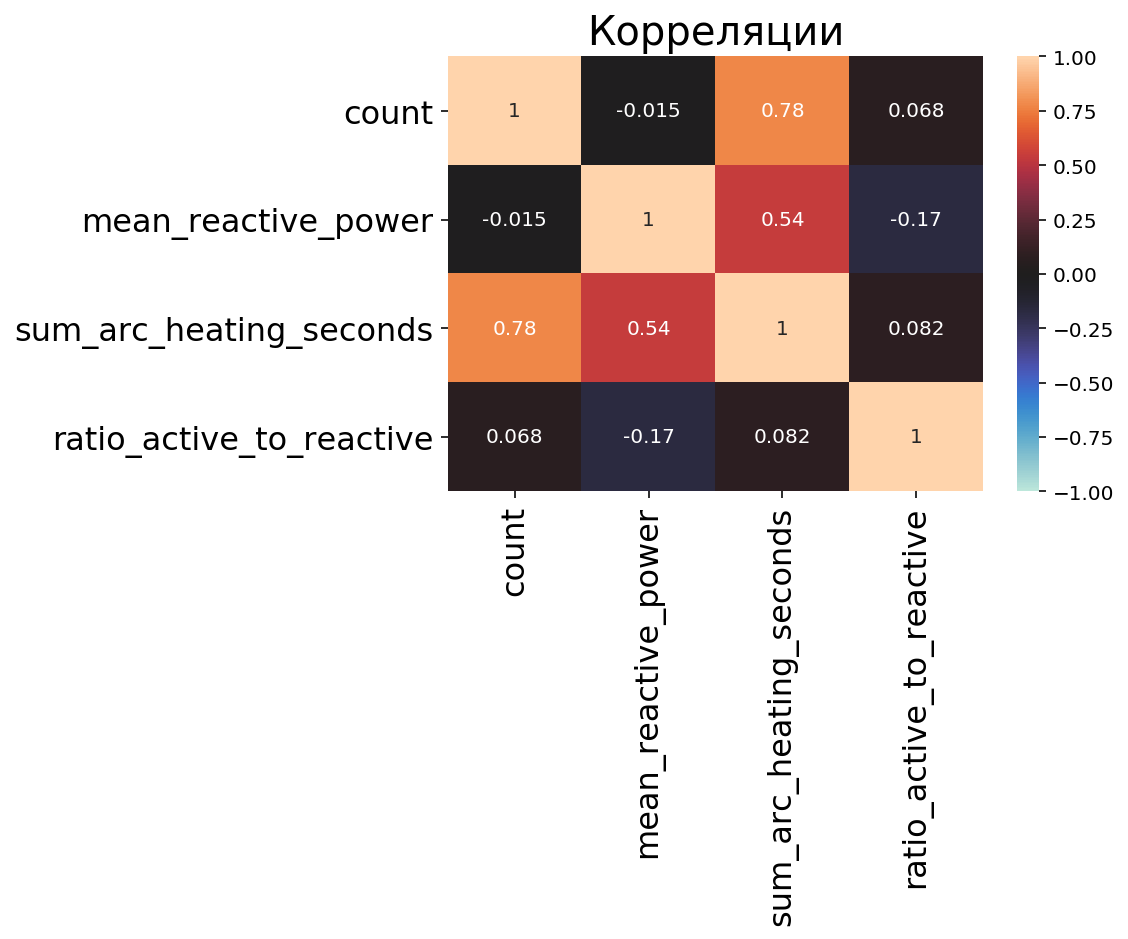

In [62]:
#посмотрим на корреляцию без них
corr = pivot_data_arc.drop(['arc_heating_seconds', 'mean_active_power'], axis=1).corr()
sns.heatmap(corr, center=0, annot=True, vmin=-1, vmax=1 )
plt.title("Корреляции", fontsize=20)
plt.tick_params(labelsize=16)
plt.show()

In [63]:
#посмотрим на переменные
print_basic_info(pivot_data_arc.loc[:,['count', 'arc_heating_seconds']],0,1,0,0)


  describe  


  count  
 count      3214.00
mean          4.63
std           1.61
min           1.00
25%           4.00
50%           4.00
75%           6.00
max          16.00
Name: count, dtype: float64

  arc_heating_seconds  
 count      3214.00
mean        172.34
std          45.61
min          57.00
25%         140.00
50%         168.75
75%         200.38
max         380.00
Name: arc_heating_seconds, dtype: float64


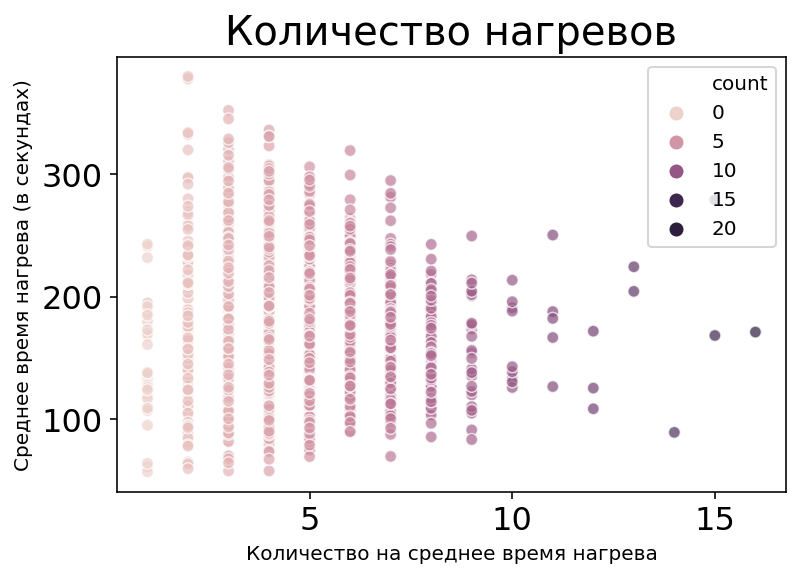

In [64]:
sns.scatterplot(data=pivot_data_arc, y="arc_heating_seconds", x="count", 
                hue="count", alpha=.7)
plt.xlabel('Количество на среднее время нагрева')
plt.ylabel('Среднее время нагрева (в секундах)')
plt.title('Количество нагревов', fontsize=20) 
plt.tick_params(labelsize=16)
plt.show()

In [65]:
#посмотрим
print_basic_info(pivot_data_arc.loc[:,['mean_active_power', 'mean_reactive_power']],0,1,0,0)


  describe  


  mean_active_power  
 count      3214.00
mean          0.67
std           0.21
min           0.19
25%           0.52
50%           0.65
75%           0.80
max           1.82
Name: mean_active_power, dtype: float64

  mean_reactive_power  
 count      3214.00
mean          0.50
std           0.15
min           0.13
25%           0.39
50%           0.49
75%           0.60
max           1.14
Name: mean_reactive_power, dtype: float64


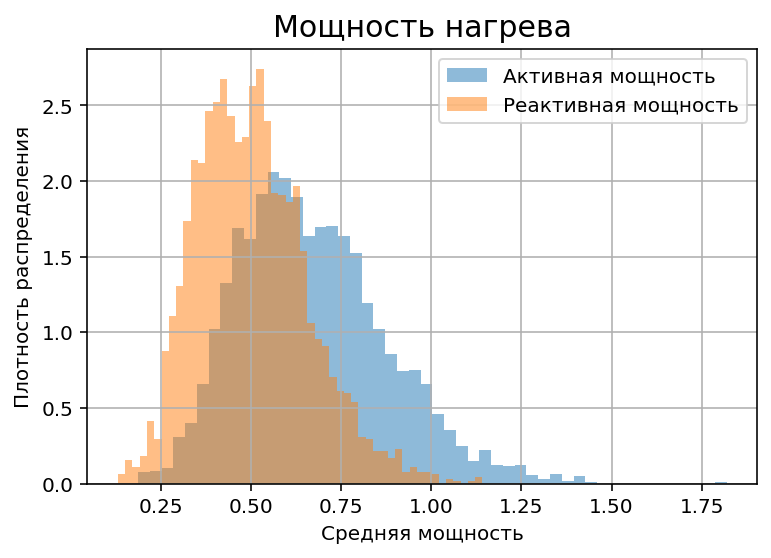

In [66]:
pivot_data_arc['mean_active_power'].hist(bins = 50, alpha=0.5, density=True)
pivot_data_arc['mean_reactive_power'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Средняя мощность')
plt.ylabel('Плотность распределения')
plt.title('Мощность нагрева', fontsize=15) 
plt.legend(['Активная мощность', 'Реактивная мощность'])
plt.show()

Средняя активная мощность чуть выше.

### Данные о подаче сыпучих материалов (объём, время подачи) (data_bulk, data_bulk_time)
<a name="3."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [67]:
#данные о подаче сыпучих материалов (объём);
print_basic_info(data_bulk,1,0,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_bulk['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

  head 


key     Bulk 1     Bulk 2     Bulk 3     Bulk 4     Bulk 5     Bulk 6  \
0    1        nan        nan        nan      43.00        nan        nan   
1    2        nan        nan        nan      73.00        nan        nan   
2    3        nan        nan        nan      34.00        nan        nan   
3    4        nan        nan        nan      81.00        nan        nan   
4    5        nan        nan        nan      78.00        nan        nan   

      Bulk 7     Bulk 8     Bulk 9    Bulk 10    Bulk 11    Bulk 12  \
0        nan        nan        nan        nan        nan     206.00   
1        nan        nan        nan        nan        nan     206.00   
2        nan        nan        nan        nan        nan     205.00   
3        nan        nan        nan        nan        nan     207.00   
4        nan        nan        nan        nan        nan     203.00   

     Bulk 13    Bulk 14    Bulk 15  
0        nan     150.00     154.00  
1        nan     149.00     154.00  
2        nan     152.00     153.00  
3        nan     153.00     154.00  
4        nan     151.00     152.00


  duplicated  

0

  unique keys  



3129

Всего 3129 кейсов

* Уникальных 3129 что больше чем в первой файле.
* Надо будет оставить key только начиная с первого этапа.
* Всего 15 видов про видов примесей.

In [68]:
#данные о подаче сыпучих материалов (время)
print_basic_info(data_bulk_time,1,0,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_bulk_time['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

  head 


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56


  duplicated  

0

  unique keys  



3129

Количество заполненных ячеек в столбцах в базе совпадает. 
Можно посмотреть, что вбрасывалось и сколько раз по времени. Что прекрасно.

### Данные данные о продувке сплава газом (data_gas)
<a name="4."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [69]:
#данные данные о продувке сплава газом;
print_basic_info(data_gas,1,1,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_gas['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

  head 


key      Газ 1
0    1      29.75
1    2      12.56
2    3      28.55
3    4      18.84
4    5       5.41


  describe  


  key  
 count      3239.00
mean       1621.86
std         935.39
min           1.00
25%         812.50
50%        1622.00
75%        2431.50
max        3241.00
Name: key, dtype: float64

  Газ 1  
 count      3239.00
mean         11.00
std           6.22
min           0.01
25%           7.04
50%           9.84
75%          13.77
max          78.00
Name: Газ 1, dtype: float64

  duplicated  

0

  unique keys  



3239

Продувка газом производилась один раз.

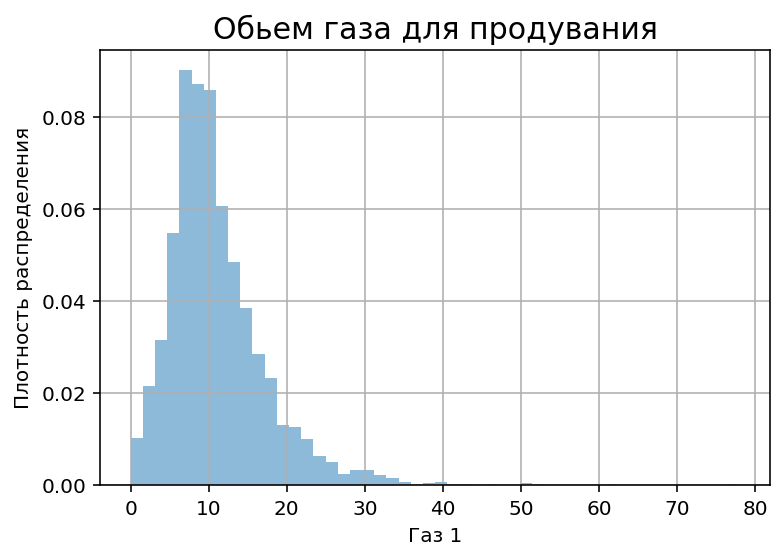

In [70]:
data_gas['Газ 1'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Газ 1')
plt.ylabel('Плотность распределения')
plt.title('Обьем газа для продувания', fontsize=15) 
plt.show()

В среднем требуется 11 единиц газа. Есть выбросы в большую сторону но не многочисленные.

### Данные о проволочных материалах (объём, время) (data_wire, data_wire_time)
<a name="5."></a>
[<font size="2">(к содержанию)</font>](#1common.)



In [71]:
##данные о проволочных материалах (объём)
print_basic_info(data_wire,1,0,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_wire['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

  head 


key     Wire 1     Wire 2     Wire 3     Wire 4     Wire 5     Wire 6  \
0    1      60.06        nan        nan        nan        nan        nan   
1    2      96.05        nan        nan        nan        nan        nan   
2    3      91.16        nan        nan        nan        nan        nan   
3    4      89.06        nan        nan        nan        nan        nan   
4    5      89.24       9.11        nan        nan        nan        nan   

      Wire 7     Wire 8     Wire 9  
0        nan        nan        nan  
1        nan        nan        nan  
2        nan        nan        nan  
3        nan        nan        nan  
4        nan        nan        nan


  duplicated  

0

  unique keys  



3081

In [72]:
#данные о проволочных материалах (время).
print_basic_info(data_wire_time,1,0,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_wire_time['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

  head 


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN


  duplicated  

0

  unique keys  



3081

3081 - уникальных значений, в прошлых базах было 3216

In [73]:
#Найдем различие в кейсах
def diff(first, second):
    return [item for item in first if item not in second]

#есть в wire, но нет в bulk
data_wire_bulk_diff  = diff(data_wire_time['key'].unique(), data_bulk_time['key'].unique())

#есть в bulk, но нет в wire
data_bulk_wire_diff  = diff(data_bulk_time['key'].unique(), data_wire_time['key'].unique())

#Разница
print("data_wire_bulk_diff:",len(data_wire_bulk_diff), ", data_bulk_wire_diff:",len(data_bulk_wire_diff))

data_wire_bulk_diff: 56 , data_bulk_wire_diff: 104


160 содержат только один вид добавок (bulk или wire)

### Результаты измерения температуры (data_temp)
<a name="6."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [74]:
#результаты измерения температуры;
print_basic_info(data_temp,1,1,1,5)

#уникальных ключей
print("\n", bold(),colored('unique keys','green'),bold_end(),"\n")
len(data_temp['key'].unique())


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

  head 


key         Время замера  Температура
0    1  2019-05-03 11:16:18      1571.00
1    1  2019-05-03 11:25:53      1604.00
2    1  2019-05-03 11:29:11      1618.00
3    1  2019-05-03 11:30:01      1601.00
4    1  2019-05-03 11:30:39      1613.00


  describe  


  key  
 count     15907.00
mean       1607.88
std         942.21
min           1.00
25%         790.00
50%        1618.00
75%        2427.00
max        3241.00
Name: key, dtype: float64

  Время замера  
 count                   15907
unique                  15907
top       2019-06-02 00:48:45
freq                        1
Name: Время замера, dtype: object

  Температура  
 count     13006.00
mean       1591.84
std          21.38
min        1191.00
25%        1581.00
50%        1591.00
75%        1601.00
max        1705.00
Name: Температура, dtype: float64

  duplicated  

0

  unique keys  



3216

3216 - уникальных ключей, но есть повторения 15907.

!Есть пропуски в температуре.

В какие моменты измеряется температура?

Будет ли доступна промежуточная температура в реальном кейсе? 

In [75]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

#Минимум и максимум в каждой key

pivot_arc_time = data_arc.pivot_table(index='key', 
                                      values=['Начало нагрева дугой', 'Конец нагрева дугой'], 
                                      aggfunc=['min','max'])
pivot_arc_time.columns = (['__','arc_heating_bg','arc_heating_end','_'])
pivot_arc_time.drop(['__','_'], axis=1, inplace = True)
pivot_arc_time.head(3)

arc_heating_bg     arc_heating_end
key                                        
1   2019-05-03 11:02:14 2019-05-03 11:28:37
2   2019-05-03 11:34:14 2019-05-03 11:53:18
3   2019-05-03 12:06:54 2019-05-03 12:32:19

<!-- #заполим пустоты левым числом
data_bulk_time.iloc[:,1:] = data_bulk_time.iloc[:,1:].fillna("2000-01-01 00:00:00")
#поправим формат
data_bulk_time['Bulk 1'] = pd.to_datetime(data_bulk_time['Bulk 1'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 2'] = pd.to_datetime(data_bulk_time['Bulk 2'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 3'] = pd.to_datetime(data_bulk_time['Bulk 3'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 4'] = pd.to_datetime(data_bulk_time['Bulk 4'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 5'] = pd.to_datetime(data_bulk_time['Bulk 5'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 6'] = pd.to_datetime(data_bulk_time['Bulk 6'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 7'] = pd.to_datetime(data_bulk_time['Bulk 7'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 8'] = pd.to_datetime(data_bulk_time['Bulk 8'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 9'] = pd.to_datetime(data_bulk_time['Bulk 9'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 10'] = pd.to_datetime(data_bulk_time['Bulk 10'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 11'] = pd.to_datetime(data_bulk_time['Bulk 11'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 12'] = pd.to_datetime(data_bulk_time['Bulk 12'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 13'] = pd.to_datetime(data_bulk_time['Bulk 13'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 14'] = pd.to_datetime(data_bulk_time['Bulk 14'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 15'] = pd.to_datetime(data_bulk_time['Bulk 15'], format='%Y-%m-%d %H:%M:%S')

#найдем дату
data_bulk_time['max_time_bulk'] = (data_bulk_time.iloc[:,1:]).max(axis = 1)
#отрежем
pivot_bulk_time = data_bulk_time
pivot_bulk_time.index = pivot_bulk_time['key']
pivot_bulk_time = pivot_bulk_time.loc[:,['max_time_bulk']]

pivot_arc_time = pivot_arc_time.join(pivot_bulk_time)
pivot_arc_time.head(3) -->
<!-- 
#заполим пустоты левым числом
data_wire_time.iloc[:,1:] = data_wire_time.iloc[:,1:].fillna("2000-01-01 00:00:00")
#поправим формат
data_wire_time['Wire 1'] = pd.to_datetime(data_wire_time['Wire 1'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 2'] = pd.to_datetime(data_wire_time['Wire 2'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 3'] = pd.to_datetime(data_wire_time['Wire 3'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 4'] = pd.to_datetime(data_wire_time['Wire 4'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 5'] = pd.to_datetime(data_wire_time['Wire 5'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 6'] = pd.to_datetime(data_wire_time['Wire 6'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 7'] = pd.to_datetime(data_wire_time['Wire 7'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 8'] = pd.to_datetime(data_wire_time['Wire 8'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 9'] = pd.to_datetime(data_wire_time['Wire 9'], format='%Y-%m-%d %H:%M:%S')

#найдем дату
data_wire_time['max_time_wire'] = (data_wire_time.iloc[:,1:]).max(axis = 1)
#отрежем
pivot_wire_time = data_wire_time
pivot_wire_time.index = pivot_wire_time['key']
pivot_wire_time = pivot_wire_time.loc[:,['max_time_wire']]

pivot_arc_time = pivot_arc_time.join(pivot_wire_time)
pivot_arc_time.head(3) -->

In [76]:
#Когда мерили температуру
def when_temp(x):
    i = x['key']
    time = x['Время замера']
    if i in pivot_arc_time.index.values:
        if time < pivot_arc_time.loc[i]['arc_heating_bg']:
            return "До нагревания дугой"
        if (pivot_arc_time.loc[i]['arc_heating_bg'] <= time) and (time <= pivot_arc_time.loc[i]['arc_heating_end']):
            return "Во время нагревания дугой"
        if pivot_arc_time.loc[i]['arc_heating_end'] < time:
            return "После нагревания дугой"
    return "Неизвестно"

#применяем 
data_temp['when_temp'] = data_temp.apply(when_temp, axis=1)

In [77]:
print(bold(), colored("В какие моменты мерили температуру? ",'blue') , bold_end(), "\n")
display(data_temp['when_temp'].value_counts(normalize=True))

 В какие моменты мерили температуру?   



Во время нагревания дугой         0.71
После нагревания дугой            0.29
До нагревания дугой               0.00
Неизвестно                        0.00
Name: when_temp, dtype: float64

71% замеров произошли во время нагревания дугой.

In [78]:
#сделаем таблицу из последних замеров
pivot_temp_max_time = data_temp.pivot_table(index='key', values=['Время замера'], aggfunc=['max'])
pivot_temp_max_time = pivot_temp_max_time.reset_index()
pivot_temp_max_time.columns = ['key','Время замера']

#применяем 
pivot_temp_max_time['when_temp'] = pivot_temp_max_time.apply(when_temp, axis=1)

In [79]:
# выведем 
print(bold(), colored("Когда замерили последнюю температуру",'blue') , bold_end(), "\n")
print((pivot_temp_max_time['when_temp'].value_counts(normalize=False)))

 Когда замерили последнюю температуру  

После нагревания дугой       3045
Во время нагревания дугой     169
Неизвестно                      2
Name: when_temp, dtype: int64


**!Последние замеры произошли не только после нагревания, но и вовремя.**

### Список уточняющих вопросов и Примерный план решения задачи.  
<a name="7."></a>
[<font size="2">(к содержанию)</font>](#1common.)

#### Список уточняющих вопросов.

1) Ранее на сайте с ТЗ была пометка с доп. информацией:
* Целевой признак: последняя измеренная температура.
* Метрика: MAE
* Критерии оценки:
    * MAE > 8.7 — 0 sp
    * 7.6 < MAE ≤ 8.7 — 4 sp
    * 6.8 < MAE ≤ 7.6 — 4.5 sp
    * 6.3 < MAE ≤ 6.8 — 5 sp
    * 6.0 < MAE ≤ 6.3 — 5.5 sp
    * MAE ≤ 6.0 — 6 sp

**Уточните, корректны ли эти критерии для текущей версии проекта. И если нет, что именно поменялось?**

2) Не все последние замеры происходили после окончания нагрева. (169 - во время нагревания дугой).
**Исключаем данные кейсы или берем в работу?**

2) **Есть ли какие-либо технические ограничения по использованию потенциальной модели?** (например, скорость предсказания, вес модели).

3) **Информация о замерах на производстве может поступать не сразу. Будут ли доступны все промежуточные замеры температуры в реальных кейсах? Если, нет то уточните на каких стадиях будет не доступна?** 

#### Примерный план решения задачи.  

* **Почистить данные:**
    * Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
    * Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).
    
    
* **Подготовить данные для модели:**
    * Разделение дата сета на тестовый и тренинговый/валидационный.
    * Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.


* **Построить модели:**
    * Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
    * Проверить модель на адекватность.

## Код решения
<a name="9."></a>
[<font size="2">(к содержанию)</font>](#1common.)

<div class="alert alert-block alert-warning">
<h3> Информация по результатам Зума с Тим-лидером:</h3>
    
* Подтверждено:
    * Целевой признак: последняя измеренная температура.
    * Метрика: MAE
    * Критерии оценки:
        * MAE > 8.7 — 0 sp
        * 7.6 < MAE ≤ 8.7 — 4 sp
        * 6.8 < MAE ≤ 7.6 — 4.5 sp
        * 6.3 < MAE ≤ 6.8 — 5 sp
        * 6.0 < MAE ≤ 6.3 — 5.5 sp
        * MAE ≤ 6.0 — 6 sp
    
* Промежуточные замеры температуры в признаки не берем. Только первоначальный.
    
* Кейсы которые берем в работу должны содержать первичный и финальный замер температуры.
* Кейсы с последним измерением температуры во время нагревания дугой - не берем.
    
* Доп. ограничений по выбору модели нет

</div>

### Чистка данных
<a name="10."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
* Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).

Сначала поймем какие кейсы мы берем в работу. Для этого необходимо найти первую и последнюю температуру и сравнить их по времени.<br>
Выкидываем если время это одинаковое (а значит был только один замер).

In [81]:
#data_temp[data_temp['key'] == 3205]

In [34]:
# отбросим na
data_temp = data_temp.dropna()

In [35]:
# добавим 
temp_info = pd.DataFrame()

temp_info['start_time'] = data_temp.sort_values('Время замера').groupby('key').first()['Время замера']
temp_info['end_time'] = data_temp.sort_values('Время замера').groupby('key').last()['Время замера']
temp_info['start_temp'] = data_temp.sort_values('Время замера').groupby('key').first()['Температура']
temp_info['end_temp'] = data_temp.sort_values('Время замера').groupby('key').last()['Температура']

In [36]:
#посмотрим разницу
temp_info['full_time'] = temp_info['end_time'] - temp_info['start_time']
#посчитаем
len(temp_info[temp_info['full_time'] == '00:00:00'])

741

In [45]:
temp_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   start_time  3216 non-null   datetime64[ns] 
 1   end_time    3216 non-null   datetime64[ns] 
 2   start_temp  3216 non-null   float64        
 3   end_temp    3216 non-null   float64        
 4   full_time   3216 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), timedelta64[ns](1)
memory usage: 150.8 KB


In [43]:
temp_info[temp_info['full_time'] == '00:00:00']

start_time            end_time  start_temp   end_temp full_time
key                                                                          
195  2019-05-10 14:10:23 2019-05-10 14:10:23     1583.00    1583.00    0 days
279  2019-05-13 23:07:28 2019-05-13 23:07:28     1603.00    1603.00    0 days
2500 2019-08-06 03:11:31 2019-08-06 03:11:31     1539.00    1539.00    0 days
2501 2019-08-06 03:44:42 2019-08-06 03:44:42     1587.00    1587.00    0 days
2502 2019-08-06 04:45:26 2019-08-06 04:45:26     1583.00    1583.00    0 days
...                  ...                 ...         ...        ...       ...
3237 2019-08-31 22:44:04 2019-08-31 22:44:04     1569.00    1569.00    0 days
3238 2019-08-31 23:30:31 2019-08-31 23:30:31     1584.00    1584.00    0 days
3239 2019-09-01 01:31:47 2019-09-01 01:31:47     1598.00    1598.00    0 days
3240 2019-09-01 02:39:01 2019-09-01 02:39:01     1617.00    1617.00    0 days
3241 2019-09-01 04:03:30 2019-09-01 04:03:30     1586.00    1586.00    0 days

[741 rows x 5 columns]

In [42]:
temp_info[temp_info['full_time'] == '00:00:00'].index.values

array([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508,
       2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519,
       2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530,
       2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541,
       2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552,
       2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563,
       2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585,
       2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596,
       2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607,
       2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618,
       2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629,
       2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640,
       2641, 2642, 2643, 2644, 2645, 2646, 2647, 26

In [37]:
#откинем
temp_info = temp_info[temp_info['full_time'] != '00:00:00']

#проверим
len(temp_info[temp_info['full_time'] == '00:00:00'])

0

Сделаем доп.проверку и посморим когда замерили последнюю температуру

In [38]:
#приведем в нужный вид для функции
tmp_temp_info = temp_info['end_time']
tmp_temp_info.name = 'Время замера'
tmp_temp_info = tmp_temp_info.reset_index()

tmp_temp_info.head()

key        Время замера
0    1 2019-05-03 11:30:39
1    2 2019-05-03 11:59:12
2    3 2019-05-03 12:34:57
3    4 2019-05-03 12:59:25
4    5 2019-05-03 13:36:01

In [39]:
#применяем 
tmp_temp_info['when_temp'] = tmp_temp_info.apply(when_temp, axis=1)
        
# выведем 
print(bold(), colored("Когда замерили последнюю температуру",'blue') , bold_end(), "\n")
print((tmp_temp_info['when_temp'].value_counts(normalize=False)))

 Когда замерили последнюю температуру  

После нагревания дугой       2344
Во время нагревания дугой     131
Name: when_temp, dtype: int64


In [40]:
#откинем кейсы Во время нагревания дугой
bad_keys = tmp_temp_info[tmp_temp_info['when_temp'] == 'Во время нагревания дугой']['key']
temp_info = temp_info.query('index not in @bad_keys')

len(temp_info)

2344

In [41]:
del(tmp_temp_info)
#проверим
tmp_temp_info = temp_info['end_time']
tmp_temp_info.name = 'Время замера'
tmp_temp_info = tmp_temp_info.reset_index()
tmp_temp_info['when_temp'] = tmp_temp_info.apply(when_temp, axis=1)
        
# выведем 
print(bold(), colored("Когда замерили последнюю температуру",'blue') , bold_end(), "\n")
print((tmp_temp_info['when_temp'].value_counts(normalize=False)))
del(tmp_temp_info)

 Когда замерили последнюю температуру  

После нагревания дугой    2344
Name: when_temp, dtype: int64


Отлично. Теперь у нас есть 2344 кейса в работу. 

Можем дополнить их информацией из других баз.

У нас уже есть таблица pivot_data_arc - об электродах, а информация о газе есть всего в одном столбце.

**Но нам необходимо обработать информацию из data_bulk и data_wire, до формата признаков**

In [42]:
# соединим таблицы. Чтобы ничего не потерять - будем использовать наш индекс из температуры.
data_dopant = pd.DataFrame(index = temp_info.index)

data_bulk.index = data_bulk['key']
data_wire.index = data_wire['key']

data_dopant = data_dopant.join(data_bulk.drop(['key'], axis=1))
data_dopant = data_dopant.join(data_wire.drop(['key'], axis=1))

#заполним пустоты нулями
data_dopant = data_dopant.fillna(0)

data_dopant.head(3)

Bulk 1     Bulk 2     Bulk 3     Bulk 4     Bulk 5     Bulk 6  \
key                                                                     
1         0.00       0.00       0.00      43.00       0.00       0.00   
2         0.00       0.00       0.00      73.00       0.00       0.00   
3         0.00       0.00       0.00      34.00       0.00       0.00   

        Bulk 7     Bulk 8     Bulk 9    Bulk 10  ...    Bulk 15     Wire 1  \
key                                              ...                         
1         0.00       0.00       0.00       0.00  ...     154.00      60.06   
2         0.00       0.00       0.00       0.00  ...     154.00      96.05   
3         0.00       0.00       0.00       0.00  ...     153.00      91.16   

        Wire 2     Wire 3     Wire 4     Wire 5     Wire 6     Wire 7  \
key                                                                     
1         0.00       0.00       0.00       0.00       0.00       0.00   
2         0.00       0.00       0.00       0.00       0.00       0.00   
3         0.00       0.00       0.00       0.00       0.00       0.00   

        Wire 8     Wire 9  
key                        
1         0.00       0.00  
2         0.00       0.00  
3         0.00       0.00  

[3 rows x 24 columns]

<!-- # #Сделаем переменные True/False
# for i in data_dopant.columns:
#     data_dopant[i.split()[0]+"_"+i.split()[1]] = data_dopant[i] > 0
# #найдем сумму data_bulk
# data_dopant['amount_bulk'] = (data_dopant.iloc[:,:15]).sum(axis = 1)
# #найдем сумму data_bulk
# data_dopant['amount_wire'] = (data_dopant.iloc[:,15:24]).sum(axis = 1) -->
**Наконец соединим таблицы**

In [43]:
#температура
data_united = temp_info.join(pivot_data_arc)
#bulk и wire
data_united = data_united.join(data_dopant)
#газ
data_united = data_united.join(data_gas.loc[:,['Газ 1']])

data_united.head(3)

start_time            end_time  start_temp   end_temp full_time  \
key                                                                            
1   2019-05-03 11:16:18 2019-05-03 11:30:39     1571.00    1613.00  00:14:21   
2   2019-05-03 11:37:27 2019-05-03 11:59:12     1581.00    1602.00  00:21:45   
3   2019-05-03 12:13:17 2019-05-03 12:34:57     1596.00    1599.00  00:21:40   

     count  arc_heating_seconds  mean_active_power  mean_reactive_power  \
key                                                                       
1        5               219.60               0.98                 0.64   
2        4               202.75               0.76                 0.50   
3        5               131.00               0.51                 0.32   

     sum_arc_heating_seconds  ...     Wire 1     Wire 2     Wire 3     Wire 4  \
key                           ...                                               
1                       1098  ...      60.06       0.00       0.00       0.00   
2                        811  ...      96.05       0.00       0.00       0.00   
3                        655  ...      91.16       0.00       0.00       0.00   

        Wire 5     Wire 6     Wire 7     Wire 8     Wire 9      Газ 1  
key                                                                    
1         0.00       0.00       0.00       0.00       0.00      12.56  
2         0.00       0.00       0.00       0.00       0.00      28.55  
3         0.00       0.00       0.00       0.00       0.00      18.84  

[3 rows x 36 columns]

In [44]:
#поправим мелочи

#удалим arc_heating_seconds, mean_active_power
data_united = data_united.drop(['arc_heating_seconds','mean_active_power'], axis=1) 

#переведем время в секунды и выкинем начало и конец 
data_united['full_time'] = data_united['full_time'].dt.seconds

data_united = data_united.drop(['start_time','end_time'], axis=1) 

#перименуем Газ1
data_united = data_united.rename(columns={"Газ 1": "Gaz"})

#сделаем нижний регистр колонок
data_united = data_united.rename(str.lower, axis='columns')

In [45]:
# Посмотрим все ли кейсы заполнены.
data_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start_temp                2344 non-null   float64
 1   end_temp                  2344 non-null   float64
 2   full_time                 2344 non-null   int64  
 3   count                     2344 non-null   int64  
 4   mean_reactive_power       2344 non-null   float64
 5   sum_arc_heating_seconds   2344 non-null   int64  
 6   ratio_active_to_reactive  2344 non-null   float64
 7   bulk 1                    2344 non-null   float64
 8   bulk 2                    2344 non-null   float64
 9   bulk 3                    2344 non-null   float64
 10  bulk 4                    2344 non-null   float64
 11  bulk 5                    2344 non-null   float64
 12  bulk 6                    2344 non-null   float64
 13  bulk 7                    2344 non-null   float64
 14  bulk 8  

Отлично. Все. Теперь посмотрим на корреляцию

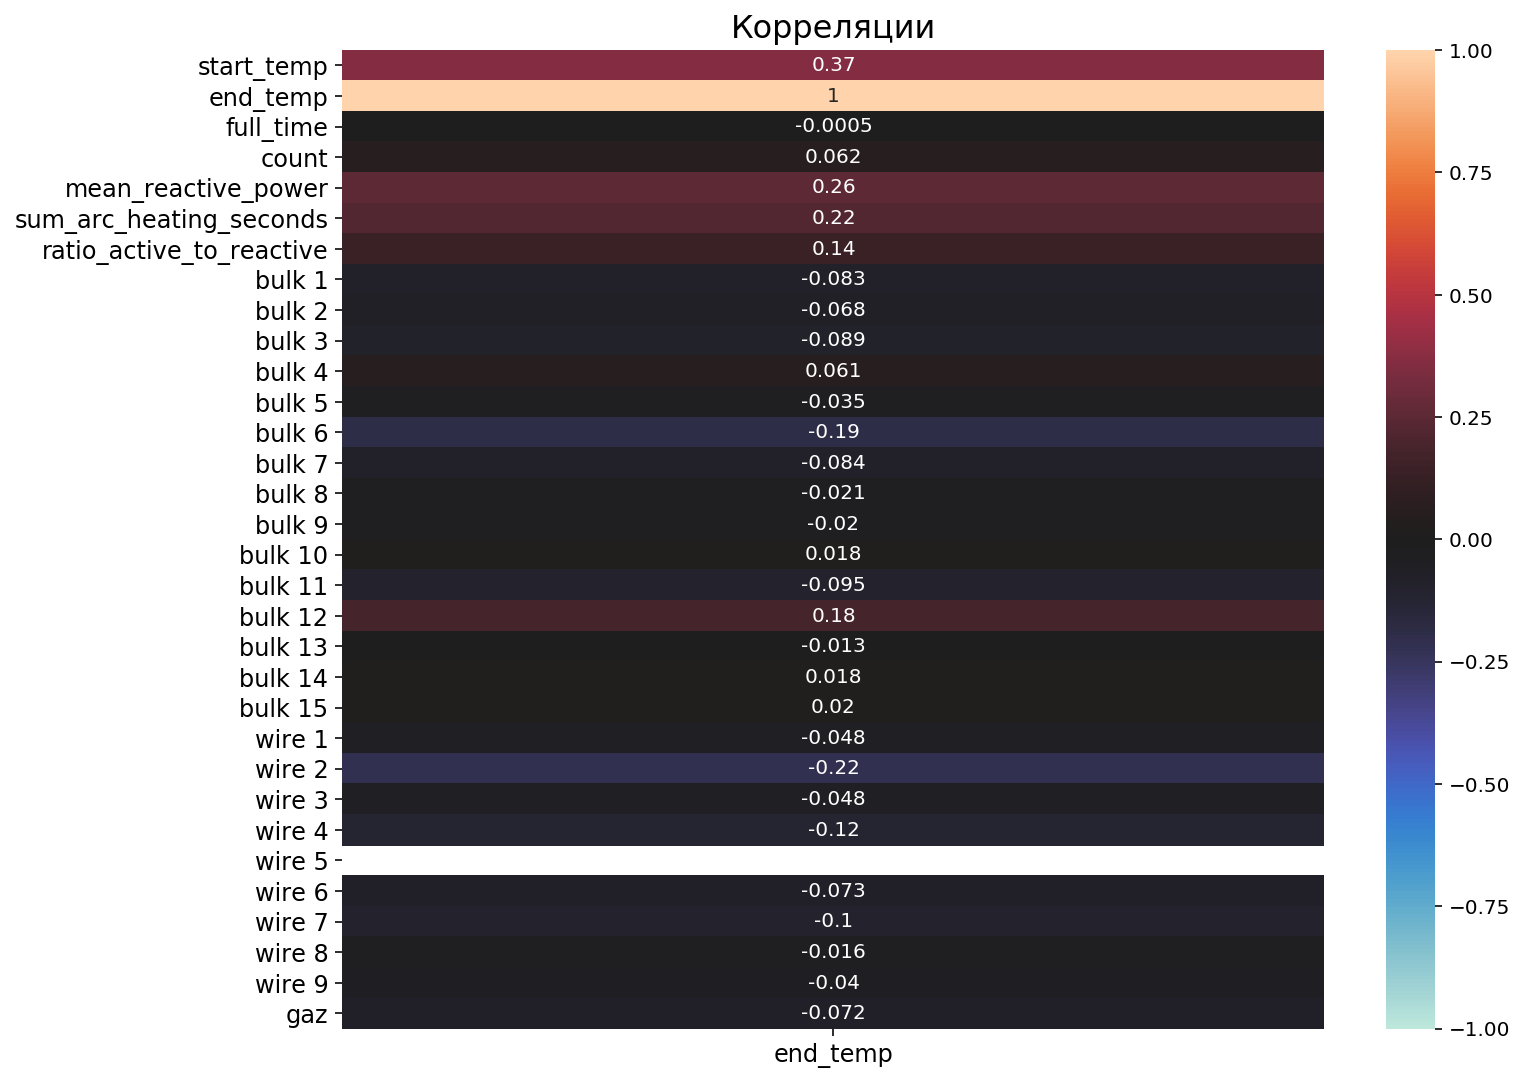

In [46]:
corr = data_united.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr.loc[:,['end_temp']],
            center=0, annot=True, vmin=-1, vmax=1)
plt.title("Корреляции", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

Больше всего влияет информация о первичной температуре, время нагрева и сила тока.
<!-- #попробуем их перемножить, чтобы сделать новую фичу
data_united['temp_power'] = data_united.start_temp * data_united.mean_active_power * data_united.mean_reactive_power -->

### Подготовка данных для модели
<a name="11."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* Разделение дата сета на тестовый и тренинговый/валидационный.
* Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.

In [47]:
#выделим таргет
features, target = data_united.drop(['end_temp'], axis=1), data_united['end_temp']

#разбиваем на train и тест (25%)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=515093)

<!-- # #Масштабируем признаки
# numeric = features_train.columns

# scaler = StandardScaler()
# scaler.fit(features_train[numeric])

# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])

# display(features_train.head())

# from sklearn.cluster import KMeans


# clustering = KMeans(n_clusters=5, random_state=515093).fit(features_train)

# features_train['clustering'] = clustering.predict(features_train)
# features_test['clustering'] = clustering.predict(features_test) -->
Посмотрим сколько осталось нетипичных случаев

In [48]:
iso = IsolationForest(random_state=0).fit(features_train)
iso_count = pd.DataFrame(index = features_train.index)
iso_count['iso'] = iso.predict(features_train)
iso_count['iso'].value_counts(normalize=False)

 1    1730
-1      28
Name: iso, dtype: int64

Немного кейсов. Удалять не будем.


### Построение модели
<a name="12."></a>
[<font size="2">(к содержанию)</font>](#1common.)
    
* Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
* Проверить модель на адекватность.

In [49]:
# прикинем какие модели подойдут т.к. нужен валидационный кусок разделим еще датасет

#разбиваем на train и валид (20%)
tmp_features_train, tmp_features_valid, tmp_target_train, tmp_target_valid = train_test_split(features_train, 
                                                                                            target_train, 
                                                                            test_size=0.20, random_state=515093)

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

models,predictions = reg.fit(tmp_features_train, tmp_features_valid, tmp_target_train, tmp_target_valid)

 88%|████████▊ | 38/43 [00:07<00:01,  3.53it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:08<00:00,  5.07it/s]


In [50]:
display(models)

R-Squared  \
Model                                                          
HistGradientBoostingRegressor                           0.70   
LGBMRegressor                                           0.66   
GradientBoostingRegressor                               0.64   
XGBRegressor                                            0.64   
ExtraTreesRegressor                                     0.64   
KNeighborsRegressor                                     0.61   
HuberRegressor                                          0.60   
RandomForestRegressor                                   0.57   
PoissonRegressor                                        0.57   
TransformedTargetRegressor                              0.56   
LinearRegression                                        0.56   
Lars                                                    0.56   
LassoLarsIC                                             0.56   
Ridge                                                   0.56   
RidgeCV                                                 0.56   
LassoCV                                                 0.56   
BayesianRidge                                           0.56   
LassoLarsCV                                             0.55   
LarsCV                                                  0.55   
BaggingRegressor                                        0.55   
SGDRegressor                                            0.55   
ElasticNetCV                                            0.51   
AdaBoostRegressor                                       0.49   
Lasso                                                   0.42   
ElasticNet                                              0.36   
OrthogonalMatchingPursuit                               0.36   
OrthogonalMatchingPursuitCV                             0.36   
PassiveAggressiveRegressor                              0.35   
SVR                                                     0.34   
NuSVR                                                   0.34   
TweedieRegressor                                        0.33   
GeneralizedLinearRegressor                              0.33   
GammaRegressor                                          0.33   
DecisionTreeRegressor                                   0.30   
ExtraTreeRegressor                                      0.20   
DummyRegressor                                         -0.00   
LassoLars                                              -0.00   
LinearSVR                                            -149.11   
MLPRegressor                                        -2391.90   
GaussianProcessRegressor                            -4241.93   
KernelRidge                                        -10573.99   
RANSACRegressor               -23697656761466599426228224.00   

                                           RMSE  Time Taken  
Model                                                        
HistGradientBoostingRegressor              8.46        1.12  
LGBMRegressor                              9.08        0.27  
GradientBoostingRegressor                  9.25        0.51  
XGBRegressor                               9.26        0.38  
ExtraTreesRegressor                        9.35        0.80  
KNeighborsRegressor                        9.69        0.06  
HuberRegressor                             9.82        0.08  
RandomForestRegressor                     10.21        1.56  
PoissonRegressor                          10.22        0.02  
TransformedTargetRegressor                10.28        0.02  
LinearRegression                          10.28        0.02  
Lars                                      10.28        0.03  
LassoLarsIC                               10.29        0.02  
Ridge                                     10.29        0.02  
RidgeCV                                   10.31        0.02  
LassoCV                                   10.33        0.12  
BayesianRidge                             10.33        0.03  
LassoLarsCV                               10.36        0

Возьмем самые привлекательные по RSME и попробудем подобрать лушие параметры.

In [51]:
#разделим на фолдеры 
cv = KFold(n_splits=3, random_state=1234, shuffle=True)

In [52]:
#XGBRegressor

grid = {'eta' : [i for i in np.arange(0.1,0.3,0.1)] , 'max_depth' : [i for i in np.arange(4,9)]}

clf = XGBRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
#gs.fit(features_train,target_train)

#XGBRegressor_best_params = gs.best_params_
#print(XGBRegressor_best_params)

In [53]:
#GradientBoostingRegressor

grid = { 'loss' : ['ls'],
        'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)] , 
        'max_depth' : [i for i in np.arange(10,15,1)]}

clf = GradientBoostingRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')
# временно закоментим для сокращения времени расчета
# gs.fit(features_train,target_train)

# GradientBoostingRegressor_best_params = gs.best_params_
# print(GradientBoostingRegressor_best_params)

In [54]:
#HistGradientBoostingRegressor

grid = {'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)] , 
        'max_depth' : [i for i in np.arange(2,5,1)]}

clf = HistGradientBoostingRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')
# временно закоментим для сокращения времени расчета
# gs.fit(features_train,target_train)

# HistGradientBoostingRegressor_best_params = gs.best_params_
# print(HistGradientBoostingRegressor_best_params)

In [55]:
#ExtraTreesRegressor

grid = {'max_depth' : [i for i in np.arange(10,15,1)], 'criterion': ['mae']}

clf = ExtraTreesRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')
# временно закоментим для сокращения времени расчета
# gs.fit(features_train,target_train)

# ExtraTreesRegressor_best_params = gs.best_params_
# print(ExtraTreesRegressor_best_params)

In [56]:
#LGBMRegressor

grid = { 'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)]}

clf = LGBMRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
# gs.fit(features_train,target_train)

# LGBMRegressor_best_params = gs.best_params_
# print(LGBMRegressor_best_params)

In [57]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания
def put_in_base(model_name, base_res, features_train, target_train):
    features_train.reset_index(drop = True, inplace = True)
    target_train.reset_index(drop = True, inplace = True)
    cv = KFold(n_splits = 3, shuffle=True, random_state=241)
    time_train, time_predict, MAE = [], [], []
    for train_index, val_index in cv.split(features_train):
        X_train, X_val = features_train.loc[train_index], features_train.loc[val_index]
        y_train, y_val = target_train.loc[train_index], target_train.loc[val_index]
        #время обучения.
        start_time = time.time()
        model_name.fit(X_train, y_train)
        time_train.append(round((time.time() - start_time),3))
        #скорость предсказания.
        start_time = time.time()
        predictions_valid = model_name.predict(X_val)
        time_predict.append(round((time.time() - start_time),3))
        #качество предсказания(MAE)
        MAE.append(mean_absolute_error(y_val, predictions_valid))
    
    if len((str(clf).split('(')[0]).split('.')) == 1:
        base_res.loc[str(clf).split('(')[0],'time_train'] = np.mean(time_train)
        base_res.loc[str(clf).split('(')[0],'time_predict'] = np.mean(time_predict)
        base_res.loc[str(clf).split('(')[0],'MAE'] = np.mean(MAE)
    else:
        nm = ((str(clf).split('(')[0]).split('.')[2]).split(' ')[0]
        base_res.loc[nm,'time_train'] = np.mean(time_train)
        base_res.loc[nm,'time_predict'] = np.mean(time_predict)
        base_res.loc[nm,'MAE'] = np.mean(MAE)
        
    return base_res

In [58]:
#запустим ее для ниших моделей с ранее найденными параметрами
ans = pd.DataFrame()

for clf in (XGBRegressor(eta = 0.1, max_depth = 6, random_state = 123),
            GradientBoostingRegressor(learning_rate = 0.2, loss = 'ls', max_depth = 10, random_state = 123),
            HistGradientBoostingRegressor(learning_rate = 0.1, loss = 'least_squares', max_depth = 4,random_state = 123),
            ExtraTreesRegressor(criterion ='mae', max_depth = 14, random_state = 123),
            LGBMRegressor(learning_rate = 0.1, random_state = 123),

            #деревья достаточно неплохо заходят. Значит можно попробовать и добавить CatBoostRegressor 
            CatBoostRegressor(random_state = 123)
           ):
    put_in_base(clf, ans, features_train, target_train)

Learning rate set to 0.040149
0:	learn: 16.1551002	total: 60ms	remaining: 59.9s
1:	learn: 15.8455781	total: 63.8ms	remaining: 31.8s
2:	learn: 15.5495528	total: 67.6ms	remaining: 22.5s
3:	learn: 15.2885083	total: 71.3ms	remaining: 17.8s
4:	learn: 15.0263549	total: 75.1ms	remaining: 14.9s
5:	learn: 14.7619940	total: 78.9ms	remaining: 13.1s
6:	learn: 14.5171044	total: 82.7ms	remaining: 11.7s
7:	learn: 14.2972297	total: 86.5ms	remaining: 10.7s
8:	learn: 14.0901678	total: 90.2ms	remaining: 9.93s
9:	learn: 13.8590416	total: 94ms	remaining: 9.3s
10:	learn: 13.6452698	total: 97.8ms	remaining: 8.79s
11:	learn: 13.4384388	total: 102ms	remaining: 8.36s
12:	learn: 13.2482938	total: 105ms	remaining: 8s
13:	learn: 13.0474734	total: 109ms	remaining: 7.68s
14:	learn: 12.8645085	total: 113ms	remaining: 7.41s
15:	learn: 12.6969047	total: 117ms	remaining: 7.17s
16:	learn: 12.5567708	total: 121ms	remaining: 6.97s
17:	learn: 12.3826998	total: 124ms	remaining: 6.78s
18:	learn: 12.2401560	total: 128ms	remain

200:	learn: 6.4049434	total: 941ms	remaining: 3.74s
201:	learn: 6.3944380	total: 945ms	remaining: 3.73s
202:	learn: 6.3782455	total: 950ms	remaining: 3.73s
203:	learn: 6.3720290	total: 956ms	remaining: 3.73s
204:	learn: 6.3569328	total: 963ms	remaining: 3.74s
205:	learn: 6.3475365	total: 973ms	remaining: 3.75s
206:	learn: 6.3402889	total: 978ms	remaining: 3.75s
207:	learn: 6.3231209	total: 982ms	remaining: 3.74s
208:	learn: 6.3111345	total: 986ms	remaining: 3.73s
209:	learn: 6.3062338	total: 989ms	remaining: 3.72s
210:	learn: 6.2946543	total: 992ms	remaining: 3.71s
211:	learn: 6.2846084	total: 995ms	remaining: 3.7s
212:	learn: 6.2674286	total: 998ms	remaining: 3.69s
213:	learn: 6.2597785	total: 1s	remaining: 3.67s
214:	learn: 6.2527444	total: 1s	remaining: 3.66s
215:	learn: 6.2427674	total: 1.01s	remaining: 3.65s
216:	learn: 6.2369998	total: 1.01s	remaining: 3.64s
217:	learn: 6.2233604	total: 1.01s	remaining: 3.63s
218:	learn: 6.2108191	total: 1.01s	remaining: 3.62s
219:	learn: 6.19890

361:	learn: 5.0992197	total: 1.5s	remaining: 2.64s
362:	learn: 5.0923902	total: 1.5s	remaining: 2.64s
363:	learn: 5.0828068	total: 1.51s	remaining: 2.63s
364:	learn: 5.0755810	total: 1.51s	remaining: 2.63s
365:	learn: 5.0675302	total: 1.52s	remaining: 2.63s
366:	learn: 5.0635195	total: 1.52s	remaining: 2.63s
367:	learn: 5.0543978	total: 1.53s	remaining: 2.62s
368:	learn: 5.0419142	total: 1.53s	remaining: 2.62s
369:	learn: 5.0341052	total: 1.54s	remaining: 2.62s
370:	learn: 5.0254045	total: 1.54s	remaining: 2.61s
371:	learn: 5.0247228	total: 1.54s	remaining: 2.61s
372:	learn: 5.0168030	total: 1.55s	remaining: 2.6s
373:	learn: 5.0085303	total: 1.55s	remaining: 2.6s
374:	learn: 5.0032044	total: 1.55s	remaining: 2.59s
375:	learn: 4.9976035	total: 1.56s	remaining: 2.58s
376:	learn: 4.9902937	total: 1.56s	remaining: 2.58s
377:	learn: 4.9827198	total: 1.56s	remaining: 2.57s
378:	learn: 4.9756220	total: 1.56s	remaining: 2.56s
379:	learn: 4.9691178	total: 1.57s	remaining: 2.56s
380:	learn: 4.95

526:	learn: 4.1903777	total: 2.05s	remaining: 1.84s
527:	learn: 4.1843525	total: 2.07s	remaining: 1.85s
528:	learn: 4.1797722	total: 2.08s	remaining: 1.86s
529:	learn: 4.1718588	total: 2.09s	remaining: 1.86s
530:	learn: 4.1664051	total: 2.1s	remaining: 1.85s
531:	learn: 4.1657670	total: 2.1s	remaining: 1.85s
532:	learn: 4.1570313	total: 2.1s	remaining: 1.84s
533:	learn: 4.1540202	total: 2.11s	remaining: 1.84s
534:	learn: 4.1463173	total: 2.11s	remaining: 1.83s
535:	learn: 4.1386666	total: 2.12s	remaining: 1.83s
536:	learn: 4.1312826	total: 2.12s	remaining: 1.83s
537:	learn: 4.1259258	total: 2.12s	remaining: 1.82s
538:	learn: 4.1236065	total: 2.13s	remaining: 1.82s
539:	learn: 4.1156075	total: 2.13s	remaining: 1.81s
540:	learn: 4.1107671	total: 2.13s	remaining: 1.81s
541:	learn: 4.1073324	total: 2.13s	remaining: 1.8s
542:	learn: 4.1030270	total: 2.14s	remaining: 1.8s
543:	learn: 4.0968771	total: 2.14s	remaining: 1.79s
544:	learn: 4.0930367	total: 2.15s	remaining: 1.79s
545:	learn: 4.084

686:	learn: 3.5029983	total: 2.62s	remaining: 1.19s
687:	learn: 3.4999232	total: 2.62s	remaining: 1.19s
688:	learn: 3.4973513	total: 2.63s	remaining: 1.18s
689:	learn: 3.4938910	total: 2.63s	remaining: 1.18s
690:	learn: 3.4906232	total: 2.63s	remaining: 1.18s
691:	learn: 3.4836012	total: 2.64s	remaining: 1.18s
692:	learn: 3.4798433	total: 2.65s	remaining: 1.17s
693:	learn: 3.4763641	total: 2.65s	remaining: 1.17s
694:	learn: 3.4733755	total: 2.65s	remaining: 1.17s
695:	learn: 3.4692212	total: 2.66s	remaining: 1.16s
696:	learn: 3.4610351	total: 2.66s	remaining: 1.16s
697:	learn: 3.4562736	total: 2.67s	remaining: 1.15s
698:	learn: 3.4513494	total: 2.67s	remaining: 1.15s
699:	learn: 3.4472507	total: 2.67s	remaining: 1.14s
700:	learn: 3.4401337	total: 2.67s	remaining: 1.14s
701:	learn: 3.4359169	total: 2.68s	remaining: 1.14s
702:	learn: 3.4317912	total: 2.68s	remaining: 1.13s
703:	learn: 3.4297962	total: 2.68s	remaining: 1.13s
704:	learn: 3.4284544	total: 2.69s	remaining: 1.12s
705:	learn: 

854:	learn: 2.9557532	total: 3.17s	remaining: 538ms
855:	learn: 2.9514169	total: 3.18s	remaining: 535ms
856:	learn: 2.9465654	total: 3.18s	remaining: 531ms
857:	learn: 2.9409171	total: 3.19s	remaining: 528ms
858:	learn: 2.9376318	total: 3.19s	remaining: 524ms
859:	learn: 2.9373846	total: 3.2s	remaining: 521ms
860:	learn: 2.9357345	total: 3.2s	remaining: 517ms
861:	learn: 2.9333038	total: 3.21s	remaining: 514ms
862:	learn: 2.9303846	total: 3.22s	remaining: 511ms
863:	learn: 2.9302253	total: 3.22s	remaining: 507ms
864:	learn: 2.9263998	total: 3.22s	remaining: 503ms
865:	learn: 2.9222387	total: 3.23s	remaining: 499ms
866:	learn: 2.9187331	total: 3.23s	remaining: 496ms
867:	learn: 2.9170288	total: 3.23s	remaining: 492ms
868:	learn: 2.9126828	total: 3.24s	remaining: 488ms
869:	learn: 2.9062804	total: 3.24s	remaining: 484ms
870:	learn: 2.9006414	total: 3.24s	remaining: 480ms
871:	learn: 2.9000837	total: 3.25s	remaining: 476ms
872:	learn: 2.8979406	total: 3.25s	remaining: 473ms
873:	learn: 2.

60:	learn: 8.7961707	total: 200ms	remaining: 3.08s
61:	learn: 8.7544174	total: 205ms	remaining: 3.11s
62:	learn: 8.7204553	total: 210ms	remaining: 3.12s
63:	learn: 8.6806277	total: 216ms	remaining: 3.16s
64:	learn: 8.6461222	total: 221ms	remaining: 3.18s
65:	learn: 8.6143966	total: 226ms	remaining: 3.2s
66:	learn: 8.5784459	total: 231ms	remaining: 3.22s
67:	learn: 8.5461089	total: 236ms	remaining: 3.24s
68:	learn: 8.5147146	total: 240ms	remaining: 3.23s
69:	learn: 8.4884660	total: 244ms	remaining: 3.24s
70:	learn: 8.4629565	total: 246ms	remaining: 3.22s
71:	learn: 8.4350987	total: 249ms	remaining: 3.21s
72:	learn: 8.4082702	total: 252ms	remaining: 3.2s
73:	learn: 8.3859753	total: 255ms	remaining: 3.19s
74:	learn: 8.3592369	total: 258ms	remaining: 3.19s
75:	learn: 8.3357002	total: 261ms	remaining: 3.18s
76:	learn: 8.3078783	total: 264ms	remaining: 3.17s
77:	learn: 8.2832352	total: 267ms	remaining: 3.16s
78:	learn: 8.2592265	total: 270ms	remaining: 3.15s
79:	learn: 8.2342665	total: 273ms

231:	learn: 5.9697536	total: 755ms	remaining: 2.5s
232:	learn: 5.9621460	total: 760ms	remaining: 2.5s
233:	learn: 5.9524079	total: 765ms	remaining: 2.5s
234:	learn: 5.9479447	total: 770ms	remaining: 2.5s
235:	learn: 5.9333321	total: 775ms	remaining: 2.51s
236:	learn: 5.9247640	total: 780ms	remaining: 2.51s
237:	learn: 5.9183226	total: 785ms	remaining: 2.51s
238:	learn: 5.9016632	total: 790ms	remaining: 2.52s
239:	learn: 5.8980808	total: 793ms	remaining: 2.51s
240:	learn: 5.8890934	total: 797ms	remaining: 2.51s
241:	learn: 5.8792076	total: 800ms	remaining: 2.5s
242:	learn: 5.8703274	total: 803ms	remaining: 2.5s
243:	learn: 5.8565269	total: 806ms	remaining: 2.5s
244:	learn: 5.8438265	total: 809ms	remaining: 2.49s
245:	learn: 5.8312254	total: 812ms	remaining: 2.49s
246:	learn: 5.8242116	total: 815ms	remaining: 2.48s
247:	learn: 5.8201799	total: 818ms	remaining: 2.48s
248:	learn: 5.8127856	total: 821ms	remaining: 2.47s
249:	learn: 5.7997292	total: 823ms	remaining: 2.47s
250:	learn: 5.78790

400:	learn: 4.6715475	total: 1.31s	remaining: 1.95s
401:	learn: 4.6610438	total: 1.31s	remaining: 1.95s
402:	learn: 4.6572333	total: 1.32s	remaining: 1.95s
403:	learn: 4.6477648	total: 1.32s	remaining: 1.95s
404:	learn: 4.6420450	total: 1.33s	remaining: 1.95s
405:	learn: 4.6400284	total: 1.33s	remaining: 1.95s
406:	learn: 4.6360969	total: 1.34s	remaining: 1.95s
407:	learn: 4.6287409	total: 1.34s	remaining: 1.95s
408:	learn: 4.6244385	total: 1.35s	remaining: 1.95s
409:	learn: 4.6191373	total: 1.36s	remaining: 1.95s
410:	learn: 4.6181582	total: 1.36s	remaining: 1.95s
411:	learn: 4.6108639	total: 1.36s	remaining: 1.94s
412:	learn: 4.6093277	total: 1.36s	remaining: 1.94s
413:	learn: 4.6077608	total: 1.37s	remaining: 1.94s
414:	learn: 4.6007705	total: 1.37s	remaining: 1.93s
415:	learn: 4.5927826	total: 1.37s	remaining: 1.93s
416:	learn: 4.5850831	total: 1.38s	remaining: 1.93s
417:	learn: 4.5758380	total: 1.38s	remaining: 1.92s
418:	learn: 4.5708349	total: 1.38s	remaining: 1.92s
419:	learn: 

611:	learn: 3.7694129	total: 2.04s	remaining: 1.29s
612:	learn: 3.7685625	total: 2.05s	remaining: 1.29s
613:	learn: 3.7634025	total: 2.05s	remaining: 1.29s
614:	learn: 3.7620901	total: 2.06s	remaining: 1.29s
615:	learn: 3.7568157	total: 2.06s	remaining: 1.28s
616:	learn: 3.7528359	total: 2.07s	remaining: 1.28s
617:	learn: 3.7492812	total: 2.07s	remaining: 1.28s
618:	learn: 3.7437227	total: 2.08s	remaining: 1.28s
619:	learn: 3.7398300	total: 2.08s	remaining: 1.27s
620:	learn: 3.7370902	total: 2.08s	remaining: 1.27s
621:	learn: 3.7307035	total: 2.09s	remaining: 1.27s
622:	learn: 3.7268039	total: 2.09s	remaining: 1.26s
623:	learn: 3.7227375	total: 2.09s	remaining: 1.26s
624:	learn: 3.7177910	total: 2.1s	remaining: 1.26s
625:	learn: 3.7168911	total: 2.1s	remaining: 1.25s
626:	learn: 3.7131199	total: 2.1s	remaining: 1.25s
627:	learn: 3.7103291	total: 2.11s	remaining: 1.25s
628:	learn: 3.7058571	total: 2.11s	remaining: 1.24s
629:	learn: 3.6999355	total: 2.11s	remaining: 1.24s
630:	learn: 3.6

820:	learn: 3.0770459	total: 2.78s	remaining: 606ms
821:	learn: 3.0768336	total: 2.79s	remaining: 603ms
822:	learn: 3.0728919	total: 2.79s	remaining: 600ms
823:	learn: 3.0691475	total: 2.79s	remaining: 597ms
824:	learn: 3.0641480	total: 2.8s	remaining: 594ms
825:	learn: 3.0638799	total: 2.81s	remaining: 591ms
826:	learn: 3.0603030	total: 2.81s	remaining: 588ms
827:	learn: 3.0600165	total: 2.81s	remaining: 585ms
828:	learn: 3.0574402	total: 2.82s	remaining: 582ms
829:	learn: 3.0545433	total: 2.82s	remaining: 578ms
830:	learn: 3.0519198	total: 2.83s	remaining: 575ms
831:	learn: 3.0489378	total: 2.83s	remaining: 572ms
832:	learn: 3.0431445	total: 2.83s	remaining: 568ms
833:	learn: 3.0386142	total: 2.84s	remaining: 565ms
834:	learn: 3.0357403	total: 2.84s	remaining: 561ms
835:	learn: 3.0353801	total: 2.84s	remaining: 558ms
836:	learn: 3.0340697	total: 2.85s	remaining: 554ms
837:	learn: 3.0318238	total: 2.85s	remaining: 551ms
838:	learn: 3.0273463	total: 2.85s	remaining: 547ms
839:	learn: 3

983:	learn: 2.6930951	total: 3.33s	remaining: 54.2ms
984:	learn: 2.6903116	total: 3.34s	remaining: 50.8ms
985:	learn: 2.6894103	total: 3.34s	remaining: 47.4ms
986:	learn: 2.6860447	total: 3.35s	remaining: 44.1ms
987:	learn: 2.6821756	total: 3.35s	remaining: 40.7ms
988:	learn: 2.6818773	total: 3.36s	remaining: 37.3ms
989:	learn: 2.6799141	total: 3.36s	remaining: 34ms
990:	learn: 2.6767078	total: 3.37s	remaining: 30.6ms
991:	learn: 2.6757696	total: 3.37s	remaining: 27.2ms
992:	learn: 2.6752485	total: 3.38s	remaining: 23.8ms
993:	learn: 2.6737685	total: 3.38s	remaining: 20.4ms
994:	learn: 2.6712954	total: 3.38s	remaining: 17ms
995:	learn: 2.6711160	total: 3.38s	remaining: 13.6ms
996:	learn: 2.6707842	total: 3.39s	remaining: 10.2ms
997:	learn: 2.6676263	total: 3.39s	remaining: 6.79ms
998:	learn: 2.6674595	total: 3.39s	remaining: 3.4ms
999:	learn: 2.6652818	total: 3.4s	remaining: 0us
Learning rate set to 0.040149
0:	learn: 15.1070081	total: 3.05ms	remaining: 3.04s
1:	learn: 14.8716693	total

185:	learn: 6.4651601	total: 632ms	remaining: 2.77s
186:	learn: 6.4510801	total: 638ms	remaining: 2.77s
187:	learn: 6.4389342	total: 643ms	remaining: 2.78s
188:	learn: 6.4283918	total: 650ms	remaining: 2.79s
189:	learn: 6.4159803	total: 655ms	remaining: 2.79s
190:	learn: 6.4005302	total: 660ms	remaining: 2.8s
191:	learn: 6.3804780	total: 665ms	remaining: 2.8s
192:	learn: 6.3654167	total: 671ms	remaining: 2.81s
193:	learn: 6.3569983	total: 679ms	remaining: 2.82s
194:	learn: 6.3481013	total: 683ms	remaining: 2.82s
195:	learn: 6.3367495	total: 686ms	remaining: 2.81s
196:	learn: 6.3212229	total: 689ms	remaining: 2.81s
197:	learn: 6.3056555	total: 692ms	remaining: 2.8s
198:	learn: 6.2926144	total: 695ms	remaining: 2.8s
199:	learn: 6.2848098	total: 698ms	remaining: 2.79s
200:	learn: 6.2733882	total: 701ms	remaining: 2.79s
201:	learn: 6.2695079	total: 704ms	remaining: 2.78s
202:	learn: 6.2605536	total: 707ms	remaining: 2.78s
203:	learn: 6.2482626	total: 711ms	remaining: 2.77s
204:	learn: 6.23

397:	learn: 4.7804909	total: 1.37s	remaining: 2.08s
398:	learn: 4.7759168	total: 1.38s	remaining: 2.08s
399:	learn: 4.7660333	total: 1.38s	remaining: 2.08s
400:	learn: 4.7567454	total: 1.39s	remaining: 2.08s
401:	learn: 4.7544604	total: 1.39s	remaining: 2.07s
402:	learn: 4.7488403	total: 1.4s	remaining: 2.07s
403:	learn: 4.7420030	total: 1.41s	remaining: 2.07s
404:	learn: 4.7338508	total: 1.41s	remaining: 2.07s
405:	learn: 4.7268251	total: 1.42s	remaining: 2.07s
406:	learn: 4.7239799	total: 1.42s	remaining: 2.07s
407:	learn: 4.7195265	total: 1.43s	remaining: 2.07s
408:	learn: 4.7125638	total: 1.43s	remaining: 2.06s
409:	learn: 4.7065563	total: 1.43s	remaining: 2.06s
410:	learn: 4.7055113	total: 1.43s	remaining: 2.06s
411:	learn: 4.6982319	total: 1.44s	remaining: 2.05s
412:	learn: 4.6961797	total: 1.44s	remaining: 2.05s
413:	learn: 4.6924348	total: 1.44s	remaining: 2.04s
414:	learn: 4.6839935	total: 1.45s	remaining: 2.04s
415:	learn: 4.6764711	total: 1.45s	remaining: 2.04s
416:	learn: 4

605:	learn: 3.8037484	total: 2.11s	remaining: 1.37s
606:	learn: 3.7981023	total: 2.12s	remaining: 1.37s
607:	learn: 3.7963168	total: 2.13s	remaining: 1.37s
608:	learn: 3.7946882	total: 2.13s	remaining: 1.37s
609:	learn: 3.7911528	total: 2.14s	remaining: 1.36s
610:	learn: 3.7850848	total: 2.14s	remaining: 1.36s
611:	learn: 3.7816809	total: 2.15s	remaining: 1.36s
612:	learn: 3.7764856	total: 2.15s	remaining: 1.36s
613:	learn: 3.7730701	total: 2.16s	remaining: 1.36s
614:	learn: 3.7686876	total: 2.16s	remaining: 1.35s
615:	learn: 3.7653766	total: 2.16s	remaining: 1.35s
616:	learn: 3.7602251	total: 2.17s	remaining: 1.34s
617:	learn: 3.7564815	total: 2.17s	remaining: 1.34s
618:	learn: 3.7524044	total: 2.17s	remaining: 1.34s
619:	learn: 3.7474098	total: 2.18s	remaining: 1.33s
620:	learn: 3.7412404	total: 2.18s	remaining: 1.33s
621:	learn: 3.7385403	total: 2.18s	remaining: 1.33s
622:	learn: 3.7356112	total: 2.19s	remaining: 1.32s
623:	learn: 3.7296905	total: 2.19s	remaining: 1.32s
624:	learn: 

785:	learn: 3.1906742	total: 2.86s	remaining: 780ms
786:	learn: 3.1872852	total: 2.89s	remaining: 781ms
787:	learn: 3.1824655	total: 2.91s	remaining: 784ms
788:	learn: 3.1798345	total: 2.92s	remaining: 781ms
789:	learn: 3.1764858	total: 2.92s	remaining: 777ms
790:	learn: 3.1726292	total: 2.93s	remaining: 774ms
791:	learn: 3.1699053	total: 2.93s	remaining: 770ms
792:	learn: 3.1678499	total: 2.94s	remaining: 767ms
793:	learn: 3.1650504	total: 2.94s	remaining: 763ms
794:	learn: 3.1617160	total: 2.94s	remaining: 760ms
795:	learn: 3.1613144	total: 2.95s	remaining: 756ms
796:	learn: 3.1590924	total: 2.95s	remaining: 753ms
797:	learn: 3.1572902	total: 2.96s	remaining: 750ms
798:	learn: 3.1529075	total: 2.97s	remaining: 746ms
799:	learn: 3.1522328	total: 2.97s	remaining: 743ms
800:	learn: 3.1502380	total: 2.98s	remaining: 740ms
801:	learn: 3.1488181	total: 2.98s	remaining: 737ms
802:	learn: 3.1464154	total: 2.99s	remaining: 734ms
803:	learn: 3.1458187	total: 3s	remaining: 731ms
804:	learn: 3.1

954:	learn: 2.7676834	total: 3.66s	remaining: 173ms
955:	learn: 2.7644427	total: 3.67s	remaining: 169ms
956:	learn: 2.7611637	total: 3.67s	remaining: 165ms
957:	learn: 2.7593276	total: 3.68s	remaining: 161ms
958:	learn: 2.7558481	total: 3.69s	remaining: 158ms
959:	learn: 2.7535130	total: 3.69s	remaining: 154ms
960:	learn: 2.7496250	total: 3.7s	remaining: 150ms
961:	learn: 2.7466595	total: 3.7s	remaining: 146ms
962:	learn: 2.7431288	total: 3.71s	remaining: 142ms
963:	learn: 2.7418902	total: 3.71s	remaining: 139ms
964:	learn: 2.7392027	total: 3.71s	remaining: 135ms
965:	learn: 2.7372020	total: 3.72s	remaining: 131ms
966:	learn: 2.7345937	total: 3.72s	remaining: 127ms
967:	learn: 2.7301671	total: 3.72s	remaining: 123ms
968:	learn: 2.7291141	total: 3.73s	remaining: 119ms
969:	learn: 2.7271433	total: 3.73s	remaining: 115ms
970:	learn: 2.7246923	total: 3.73s	remaining: 112ms
971:	learn: 2.7212346	total: 3.74s	remaining: 108ms
972:	learn: 2.7189959	total: 3.74s	remaining: 104ms
973:	learn: 2.

In [59]:
display(ans.sort_values(by = 'MAE'))

time_train  time_predict        MAE
CatBoostRegressor                    4.03          0.00       5.97
XGBRegressor                         0.31          0.00       6.24
HistGradientBoostingRegressor        0.29          0.01       6.26
LGBMRegressor                        0.10          0.01       6.34
ExtraTreesRegressor                 18.31          0.02       6.56
GradientBoostingRegressor            1.31          0.01       6.82

Лучше всего себя показал катбус. Сможем ли уменьшить количество параметров?

In [60]:
feature_importances_info = pd.DataFrame()
feature_importances_info['columns'] = features_train.columns
feature_importances_info['importances'] = clf.feature_importances_
feature_importances_info.sort_values(by = 'importances').head(10)

columns  importances
25   wire 5         0.00
13   bulk 8         0.00
18  bulk 13         0.00
29   wire 9         0.01
14   bulk 9         0.01
28   wire 8         0.01
10   bulk 5         0.08
27   wire 7         0.09
23   wire 3         0.10
7    bulk 2         0.14

3 параметра можем удалить

In [61]:
col_unnecessary = feature_importances_info.sort_values(by = 'importances').head(3)['columns'].to_list()

#удаляем
features_train = features_train.drop(col_unnecessary, axis=1)
features_test = features_test.drop(col_unnecessary, axis=1)

#### Тестирование
<a name="13."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [62]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания(RMSE)
def put_in_base_test(model_name, base_res, features_train, target_train, features_test, target_test):
    
    #время обучения.
    start_time = time.time()
    model_name.fit(features_train, target_train)
    
    if len((str(model_name).split('(')[0]).split('.')) == 1:
        nm = str(model_name).split('(')[0]
    else:
        nm = ((str(model_name).split('(')[0]).split('.')[2]).split(' ')[0]

    base_res.loc[nm,'time_train'] = round((time.time() - start_time),3)
    #скорость предсказания.
    start_time = time.time()
    predictions_test = model_name.predict(features_test)
    base_res.loc[nm,'time_predict'] = round((time.time() - start_time),3)
    #качество предсказания(mae)
    base_res.loc[nm,'MAE'] = mean_absolute_error(target_test, predictions_test)
    
    return predictions_test, model_name, base_res

In [63]:
#посмотрим на результат
info_final_test = pd.DataFrame()

final_model = CatBoostRegressor(random_state = 123)

predictions_test, final_model, info_final_test = put_in_base_test(final_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

Learning rate set to 0.043153
0:	learn: 15.8556319	total: 7.99ms	remaining: 7.99s
1:	learn: 15.5139505	total: 13.3ms	remaining: 6.61s
2:	learn: 15.2208139	total: 96.2ms	remaining: 32s
3:	learn: 14.9345674	total: 127ms	remaining: 31.7s
4:	learn: 14.6138518	total: 146ms	remaining: 29.1s
5:	learn: 14.3183589	total: 153ms	remaining: 25.3s
6:	learn: 14.0673255	total: 159ms	remaining: 22.6s
7:	learn: 13.8291159	total: 168ms	remaining: 20.8s
8:	learn: 13.6064229	total: 174ms	remaining: 19.1s
9:	learn: 13.3870436	total: 179ms	remaining: 17.7s
10:	learn: 13.1683327	total: 186ms	remaining: 16.7s
11:	learn: 12.9747446	total: 192ms	remaining: 15.8s
12:	learn: 12.7709359	total: 245ms	remaining: 18.6s
13:	learn: 12.5837979	total: 280ms	remaining: 19.7s
14:	learn: 12.3981291	total: 288ms	remaining: 18.9s
15:	learn: 12.2271858	total: 295ms	remaining: 18.1s
16:	learn: 12.0539113	total: 302ms	remaining: 17.4s
17:	learn: 11.9004262	total: 310ms	remaining: 16.9s
18:	learn: 11.7483286	total: 316ms	remainin

181:	learn: 6.6800092	total: 1.23s	remaining: 5.51s
182:	learn: 6.6754010	total: 1.23s	remaining: 5.5s
183:	learn: 6.6660044	total: 1.24s	remaining: 5.49s
184:	learn: 6.6578337	total: 1.24s	remaining: 5.48s
185:	learn: 6.6417565	total: 1.26s	remaining: 5.51s
186:	learn: 6.6270560	total: 1.27s	remaining: 5.5s
187:	learn: 6.6193635	total: 1.27s	remaining: 5.49s
188:	learn: 6.6137318	total: 1.27s	remaining: 5.47s
189:	learn: 6.6071755	total: 1.28s	remaining: 5.45s
190:	learn: 6.5973261	total: 1.28s	remaining: 5.43s
191:	learn: 6.5871307	total: 1.29s	remaining: 5.42s
192:	learn: 6.5749894	total: 1.29s	remaining: 5.4s
193:	learn: 6.5585312	total: 1.29s	remaining: 5.38s
194:	learn: 6.5550566	total: 1.3s	remaining: 5.36s
195:	learn: 6.5451567	total: 1.3s	remaining: 5.34s
196:	learn: 6.5330177	total: 1.3s	remaining: 5.32s
197:	learn: 6.5234032	total: 1.31s	remaining: 5.3s
198:	learn: 6.5136515	total: 1.31s	remaining: 5.28s
199:	learn: 6.5030001	total: 1.31s	remaining: 5.26s
200:	learn: 6.49805

358:	learn: 5.4277407	total: 1.98s	remaining: 3.54s
359:	learn: 5.4267382	total: 1.99s	remaining: 3.53s
360:	learn: 5.4233810	total: 1.99s	remaining: 3.52s
361:	learn: 5.4147611	total: 2s	remaining: 3.52s
362:	learn: 5.4080944	total: 2s	remaining: 3.52s
363:	learn: 5.4043999	total: 2.01s	remaining: 3.51s
364:	learn: 5.3965860	total: 2.02s	remaining: 3.51s
365:	learn: 5.3909022	total: 2.02s	remaining: 3.5s
366:	learn: 5.3817197	total: 2.02s	remaining: 3.49s
367:	learn: 5.3730787	total: 2.03s	remaining: 3.48s
368:	learn: 5.3645553	total: 2.03s	remaining: 3.47s
369:	learn: 5.3640814	total: 2.04s	remaining: 3.46s
370:	learn: 5.3636210	total: 2.04s	remaining: 3.46s
371:	learn: 5.3621024	total: 2.04s	remaining: 3.45s
372:	learn: 5.3565138	total: 2.05s	remaining: 3.44s
373:	learn: 5.3497064	total: 2.05s	remaining: 3.43s
374:	learn: 5.3436135	total: 2.05s	remaining: 3.42s
375:	learn: 5.3428321	total: 2.06s	remaining: 3.41s
376:	learn: 5.3396499	total: 2.06s	remaining: 3.4s
377:	learn: 5.334676

544:	learn: 4.5866477	total: 2.73s	remaining: 2.28s
545:	learn: 4.5828367	total: 2.74s	remaining: 2.28s
546:	learn: 4.5773281	total: 2.74s	remaining: 2.27s
547:	learn: 4.5769861	total: 2.75s	remaining: 2.27s
548:	learn: 4.5738458	total: 2.76s	remaining: 2.26s
549:	learn: 4.5713001	total: 2.76s	remaining: 2.26s
550:	learn: 4.5700132	total: 2.77s	remaining: 2.25s
551:	learn: 4.5636399	total: 2.77s	remaining: 2.25s
552:	learn: 4.5590633	total: 2.78s	remaining: 2.24s
553:	learn: 4.5559845	total: 2.78s	remaining: 2.24s
554:	learn: 4.5509000	total: 2.78s	remaining: 2.23s
555:	learn: 4.5492979	total: 2.79s	remaining: 2.23s
556:	learn: 4.5446670	total: 2.79s	remaining: 2.22s
557:	learn: 4.5343423	total: 2.79s	remaining: 2.21s
558:	learn: 4.5305334	total: 2.8s	remaining: 2.21s
559:	learn: 4.5254226	total: 2.8s	remaining: 2.2s
560:	learn: 4.5216439	total: 2.81s	remaining: 2.2s
561:	learn: 4.5196020	total: 2.81s	remaining: 2.19s
562:	learn: 4.5174302	total: 2.81s	remaining: 2.18s
563:	learn: 4.51

730:	learn: 3.9497756	total: 3.48s	remaining: 1.28s
731:	learn: 3.9450307	total: 3.49s	remaining: 1.28s
732:	learn: 3.9404546	total: 3.49s	remaining: 1.27s
733:	learn: 3.9376287	total: 3.5s	remaining: 1.27s
734:	learn: 3.9350215	total: 3.5s	remaining: 1.26s
735:	learn: 3.9308726	total: 3.51s	remaining: 1.26s
736:	learn: 3.9283064	total: 3.52s	remaining: 1.25s
737:	learn: 3.9233272	total: 3.52s	remaining: 1.25s
738:	learn: 3.9194501	total: 3.53s	remaining: 1.25s
739:	learn: 3.9178856	total: 3.53s	remaining: 1.24s
740:	learn: 3.9160320	total: 3.53s	remaining: 1.24s
741:	learn: 3.9120530	total: 3.54s	remaining: 1.23s
742:	learn: 3.9076506	total: 3.54s	remaining: 1.23s
743:	learn: 3.9045755	total: 3.55s	remaining: 1.22s
744:	learn: 3.9025636	total: 3.55s	remaining: 1.21s
745:	learn: 3.8996220	total: 3.55s	remaining: 1.21s
746:	learn: 3.8993326	total: 3.56s	remaining: 1.21s
747:	learn: 3.8970520	total: 3.56s	remaining: 1.2s
748:	learn: 3.8945592	total: 3.57s	remaining: 1.2s
749:	learn: 3.89

911:	learn: 3.4648342	total: 4.23s	remaining: 408ms
912:	learn: 3.4640892	total: 4.24s	remaining: 404ms
913:	learn: 3.4587515	total: 4.25s	remaining: 399ms
914:	learn: 3.4574093	total: 4.25s	remaining: 395ms
915:	learn: 3.4557328	total: 4.26s	remaining: 391ms
916:	learn: 3.4554389	total: 4.26s	remaining: 386ms
917:	learn: 3.4530948	total: 4.27s	remaining: 382ms
918:	learn: 3.4522201	total: 4.28s	remaining: 377ms
919:	learn: 3.4494359	total: 4.29s	remaining: 373ms
920:	learn: 3.4475571	total: 4.29s	remaining: 368ms
921:	learn: 3.4453130	total: 4.29s	remaining: 363ms
922:	learn: 3.4441391	total: 4.3s	remaining: 359ms
923:	learn: 3.4401075	total: 4.3s	remaining: 354ms
924:	learn: 3.4370142	total: 4.31s	remaining: 349ms
925:	learn: 3.4366648	total: 4.31s	remaining: 344ms
926:	learn: 3.4345934	total: 4.31s	remaining: 340ms
927:	learn: 3.4338783	total: 4.32s	remaining: 335ms
928:	learn: 3.4287640	total: 4.32s	remaining: 330ms
929:	learn: 3.4265083	total: 4.32s	remaining: 326ms
930:	learn: 3.

In [64]:
#выведем красиво
colors = ['rgb(107, 174, 214)']
fig = go.Figure(data=[go.Table( header=dict(
    values=['Время обучения модели (в секундах)', 
            'Время предсказания модели (в секундах)',
            'MAE на тестовой выборке'],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=15)
  ),
  cells=dict(
    values=[info_final_test.time_train.round(2), 
            info_final_test.time_predict.round(2),info_final_test.MAE.round(2)],
    line_color=[colors], fill_color=[colors],
    align='center', font=dict(color='black', size=14)
  ))
])
fig.update_layout(title_text="Показатели финальной модели (CatBoostRegressor)", height = 300)
fig.show()

#### Проверка модели на адекватность.
<a name="14."></a>
[<font size="2">(к содержанию)</font>](#1common.)

 % mean in test sample: target 1594.69 VS predictions 1594.56 


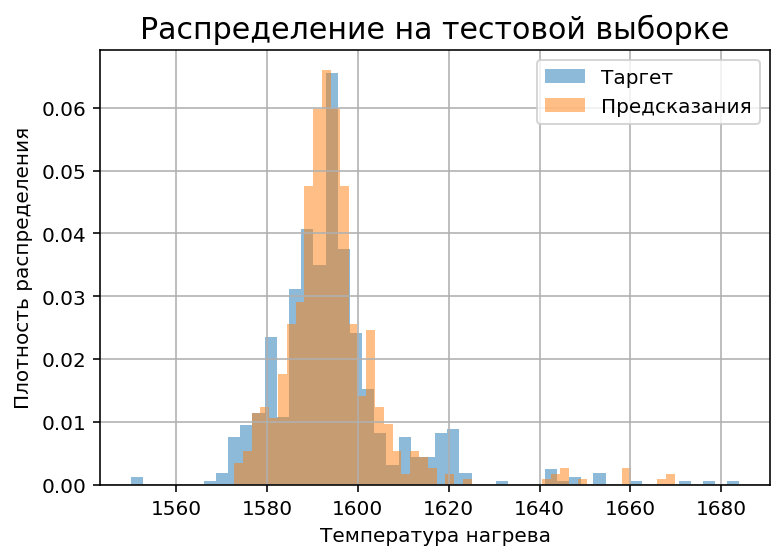

In [65]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(target_test.mean(),2),'blue')+bold(),"VS predictions",
      colored(round(predictions_test.mean() ,2),'blue'),bold_end())

target_test.hist(bins = 50, alpha=0.5, density=True)
pd.Series(predictions_test).hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

Средние похожи. Распределения также, однако предсказание ожидаемо хуже определяет крайние случаи

In [66]:
#Сравнимc дамми
dummy_model = DummyRegressor(strategy='median')

predictions_dummy, dummy_model, info_final_test = put_in_base_test(dummy_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

In [67]:
display(info_final_test)

time_train  time_predict        MAE
CatBoostRegressor        5.05          0.00       5.43
DummyRegressor           0.00          0.00       9.29

Наша модель показывает себя гораздно лучше чем Дамми

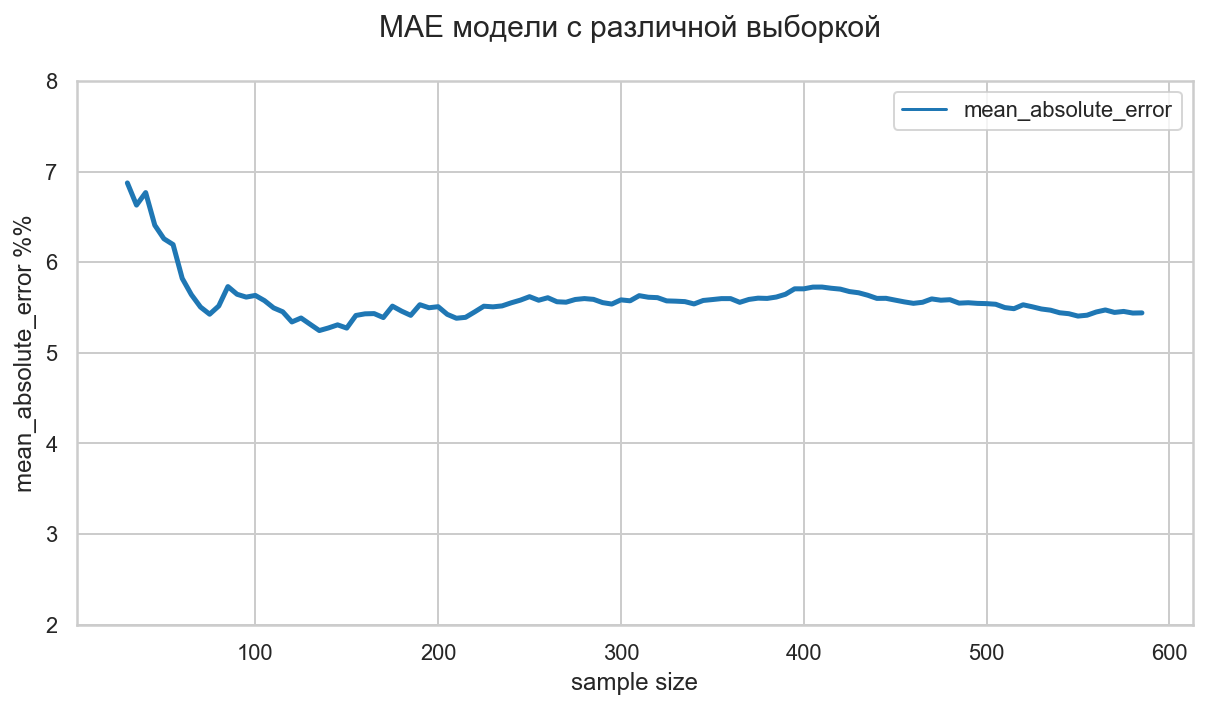

In [68]:
#**Зависимость от объема выборки**

#делаем базу. добавляем по 2 кейса увеличивая семпл
base_min = pd.DataFrame()
for i in range(30,len(target_test),5):
    base_min.loc[i,'mean_absolute_error'] = mean_absolute_error(target_test[0:i], final_model.predict(features_test[0:i]))

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.lineplot(data=base_min, palette="tab20", linewidth=2.5)
plt.title("MAE модели с различной выборкой \n", fontsize=15)
plt.ylabel("mean_absolute_error %%")
plt.xlabel("sample size")
plt.ylim((2, 8)) 
plt.show()

Модель не очень стабильна на небольшой выборке, что ожидаемо. 
<br>В целом показатель точности не сильно колеблется и далее стабилизируется.

### Вывод.
<a name="15."></a>
[<font size="2">(к содержанию)</font>](#1common.)

**На основе исторических данных о клиентах «Не бит, не крашен», была построена модель для предсказания финальной температуру стали с целью оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» и уменьшить потребление электроэнергии на этапе обработки стали.**

**Заказчику необходима модель с показателем MAE не более 8.7:**
* Полученная модель имеет на тестовой выборке МАЕ 5.43 

По результатам первичного анализа и в работу взяты:
* Кейсы содержащие минимум 2 замера температуры (первичный и окончательный).
* Кейсы с последним замером температуры после окончания нагревания дугой.

**Модель построена на основе данных о партиях на производстве*:**

* 'start_temp' - первичное измерение температуры
* 'full_time' - сколько прошло от начала первого нагревания дугой до окончания последнего
* 'count' - количество нагреваний дугой
* 'sum_arc_heating_seconds' - суммарное время нагрева дугой
* 'mean_reactive_power' - средняя реактивная мощность в процессе нагревания(в партии)
* 'ratio_active_to_reactive' - средняя соотношение активной и реактивной мощности в процессе нагревания (в партии)
* информация об объеме различных добавлений в процессе легиризации ('bulk 1','bulk 2', 'bulk 3', 'bulk 4', 'bulk 5', 'bulk 6', 'bulk 7', 'bulk 9','bulk 10', 'bulk 11', 'bulk 12', 'bulk 14', 'bulk 15', 'wire 1','wire 2', 'wire 3', 'wire 4', 'wire 6', 'wire 7', 'wire 8', 'wire 9')
* информация об объеме газа использующегося в процессе ('gaz')

***Целевой признак - Финальная температура(end_temp)***

**Модель построена с помощью CatBoostRegressor(random_state = 123):**

## Отчет по решению
<a name="16."></a>
[<font size="2">(к содержанию)</font>](#1common.)
    
**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

* Все пункты плана были выполнены. 
А именно:
    * ***Почистить данные:***
        * Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
        * Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).
    * ***Подготовить данные для модели:***
        * Разделение дата сета на тестовый и тренинговый/валидационный.
        * Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.
    * ***Построить модели:***
        * Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
        * Проверить модель на адекватность.


* **Также дополнительно была произведена:**
    * Проверка расширенная чистка кейсов на основе информации полученной в результате зум конференции с командой.
    * Проверка модели на тестовой выборке (т.к. забыла занести его в план)

**Какие трудности возникли и как вы их преодолели?**

* Был упущен момент возможной мультиколлениальности переменных. После указания на это старшего коллеги, недочет был исправлен
* Других трудностей не возникло

**Какие ключевые шаги в решении задачи выделили?**

* Понимание процесса обработки металла
* Изучение структуры предоставленных данных
* Чистка данных от некорректных значений
* Контроль утечек (чтобы не было недоступной в реальных случаях информации)
* Подготовка и построение модели
* Тестирование модели и проверка ее на адекватность

**Какая ваша итоговая модель и какое у неё качество?**

* Модель построена с помощью CatBoostRegressor(random_state = 123)
* Полученная модель имеет на тестовой выборке МАЕ 5.43